In [1]:
import gc
import sys
import pickle
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

sys.path.append('utils')
from plot_utils import fast_plot, fast_hist, fast_legend, feature_snapshot

# Загрузка данных

In [2]:
%%time
with open('../data/processed/train.pcl', 'rb') as f:
    train = pickle.load(f)
    
with open('../data/processed/test.pcl', 'rb') as f:
    test = pickle.load(f)
    
gc.collect()

Wall time: 26.3 s


0

In [3]:
def get_time_features(data):
    data['hour_shift'] = data['shift'].apply(lambda x: x.replace('MSK', ''))
    data['hour_shift'] = data['hour_shift'].replace({'': 0, 'missing': 0}).astype('int8')
    
    data['local_time'] = data['created'] + pd.to_timedelta('1H') * data['hour_shift']
    data['month'] = data['local_time'].dt.month.astype('int8')
    data['date'] = data['local_time'].dt.date
    data['day'] = data['local_time'].dt.day.astype('int8')
    data['wd'] = data['local_time'].dt.weekday.astype('int8')
    data['hour'] = data['local_time'].dt.hour.astype('int8')
    data['minutes'] = data['local_time'].dt.minute.astype('int8')
    return data

In [4]:
%%time
test = get_time_features(test)

Wall time: 8.35 s


# Параметры модели

In [5]:
target = 'Segment'
features = ['gamecategory', 'subgamecategory', 'bundle', 'oblast', 'city', 'os', 'osv', 'day', 'wd', 'hour', 'minutes']
cat_features = ['gamecategory', 'subgamecategory', 'bundle', 'oblast', 'city', 'os', 'osv']

In [6]:
%%time
train = train.sort_values(target)

Wall time: 13.8 s


In [7]:
# Model params
cat_features = ['gamecategory', 'subgamecategory', 'bundle', 'oblast', 'city', 'os', 'osv']

split_params = {'folds': 5}

model_params = {'objective': 'MultiClass', 
                'iterations':100,
                'learning_rate':0.2,               
                'depth': 5, 
                'l2_leaf_reg': 50,  
                'one_hot_max_size': 3,
                'task_type': 'GPU',
                'has_time': False,
                'random_state': 20210926                
               }

train_params = {'early_stopping_rounds': 150, 
                'silent': True,
                'plot': True               
               }

gpu_params = {'devices': '0',
              'data_partition': 'DocParallel',
              'max_ctr_complexity': 4,
              'border_count': 128, 
              'fold_permutation_block': 0,
              'simple_ctr':'FeatureFreq',
              'combinations_ctr': 'FeatureFreq',      
              'ctr_target_border_count': 1,
              'random_strength': 0.95,
              'gpu_ram_part': 0.95
             }


cpu_params = {'thread_count': 14}

features_params = {'cat_features': cat_features}

observations_params = {"weight": 'not_implemented'}

params = {'split_params': split_params, 
          'model_params': model_params, 
          'train_params': train_params, 
          'gpu_params': gpu_params, 
          'cpu_params': cpu_params, 
          'features_params': features_params, 
          'observations_params': observations_params
         }

In [8]:
class Model():
    def __init__(self, params):
        self.params = params
        self.device = params['model_params']['task_type']
        self.model_params = params['model_params']
        self.folds = params['split_params']['folds']        
        self.train_params = params['train_params']
        self.gpu_params = params['gpu_params']
        self.cpu_params = params['cpu_params']
        self.features_params = params['features_params']
        self.observations_params = params['observations_params'] 
        self.models = []
        self.model_predictions = []
        self.predictions_summary = None        
        self.importance = []
        self.features = None
        
    def fit(self, X, y): 
        self.features = X.columns
        self.model_params = self.model_params | self.gpu_params if self.device == 'GPU' else \
            self.model_params | self.cpu_params   
        
        for fold in range(self.folds):
            print(f'\nFold: {fold + 1}')
            self.model_params['random_state'] += 1 
            
            if self.folds > 1:
                train_idx = [x for x in range(X.shape[0]) if x%self.folds != fold]
                val_idx = [x for x in range(X.shape[0]) if x%self.folds == fold]            
            
                X_train = X.iloc[train_idx]
                y_train = y.iloc[train_idx]
            
                X_val = X.iloc[val_idx]
                y_val = y.iloc[val_idx] 
            else:
                X_train = X
                y_train = y

            train_dataset = Pool(data=X_train, label=y_train, **self.features_params)                
           
            model = CatBoostClassifier(**self.model_params)    
            
            if self.folds > 1:
                eval_dataset = Pool(data=X_val, label=y_val, **self.features_params)  
                model.fit(train_dataset, eval_set=eval_dataset, **self.train_params)
            else:
                model.fit(train_dataset,  **self.train_params)
            
            self.models.append(model.copy())   

        self.calculate_importance()
            
        
    def predict(self, X):
        self.model_predictions = []
        for model_number in range(self.folds):    
            model = self.models[model_number]
            columns = [str(x) + '__' + str(model_number) for x in model.get_all_params()['class_names']]
            df = pd.DataFrame(data=model.predict_proba(X), columns=columns)
            self.model_predictions.append(df)  
    
        self.predictions_summary = pd.concat(self.model_predictions, axis=1)

        labels = model.get_all_params()['class_names']
        for label in labels:
            label_columns = [x for x in self.predictions_summary.columns if f'{label}__' in str(x)]
            self.predictions_summary[label] = self.predictions_summary[label_columns].mean(axis=1)

        self.predictions_summary['prediction'] = self.predictions_summary[labels].idxmax(axis=1)
        self.predictions_summary['confidence'] = self.predictions_summary[labels].max(axis=1)
                    
        return self.predictions_summary  
  
   
    def save_models(self, path):
        for model_number, model in enumerate(self.models):
            model.save_model(path + f"model{model_number}.cbm")
            
    def load_models(self, path, file_prefix=''):
        for model_number in range(self.folds):
            model = CatBoostClassifier()
            model.load_model(path.joinpath(f"{file_prefix}model{model_number}.cbm"))
            self.models.append(model.copy())
            
    def calculate_importance(self):
        for model_number in range(self.folds):
            fi_dict = list(zip(self.features, self.models[model_number].feature_importances_))
            importance_df = pd.DataFrame.from_records(fi_dict).set_index(0)
            importance_df.columns = ['importance']
            importance_df = importance_df.sort_values('importance', ascending=False)
            self.importance.append(importance_df) 

In [9]:
%%time
model = Model(params)
model.fit(train[features], train[target])


Fold: 1


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 3


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 4


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Fold: 5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 9min 17s


In [10]:
model.save_models(path='models/segmentation_model_')

In [11]:
model.importance[0]

,importance
0,
day,50.611968
wd,18.496342
hour,15.137890
os,7.425163
oblast,3.236983
osv,1.867206
subgamecategory,1.690187
bundle,1.151699
minutes,0.313581


# Оценка модели
Метрика для задачи классификации используйте ROC-AUC (one vs rest)

In [12]:
%%time
preds = model.predict(test[features])
print(preds.shape)

(14856099, 26)
Wall time: 2min 57s


In [13]:
def calculate_score(true, preds):
    print(f'Labels equals: {true.unique() == preds["prediction"].unique()}')
    labels = [x for x in true.unique() if x in preds["prediction"].unique()]
    print(labels)
    for label in labels:
        true_ = (test[target] == label).astype(int).values
        preds_ = preds[label].values
        score = np.round(roc_auc_score(true_, preds_), 3)
        print(f'Label: {label}, score: {score}')

In [14]:
calculate_score(test[target], preds)

Labels equals: False
[3, 4, 1]
Label: 3, score: 0.456
Label: 4, score: 0.566
Label: 1, score: 0.577


In [15]:
pd.crosstab(test[target], preds['prediction'])

prediction,1,3,4
Segment,,,
1,42,56886,9659
2,284,400403,69100
3,815,1167651,200746
4,341,486754,83624
5,1457,2085458,358763


# Анализ распределений в test и train

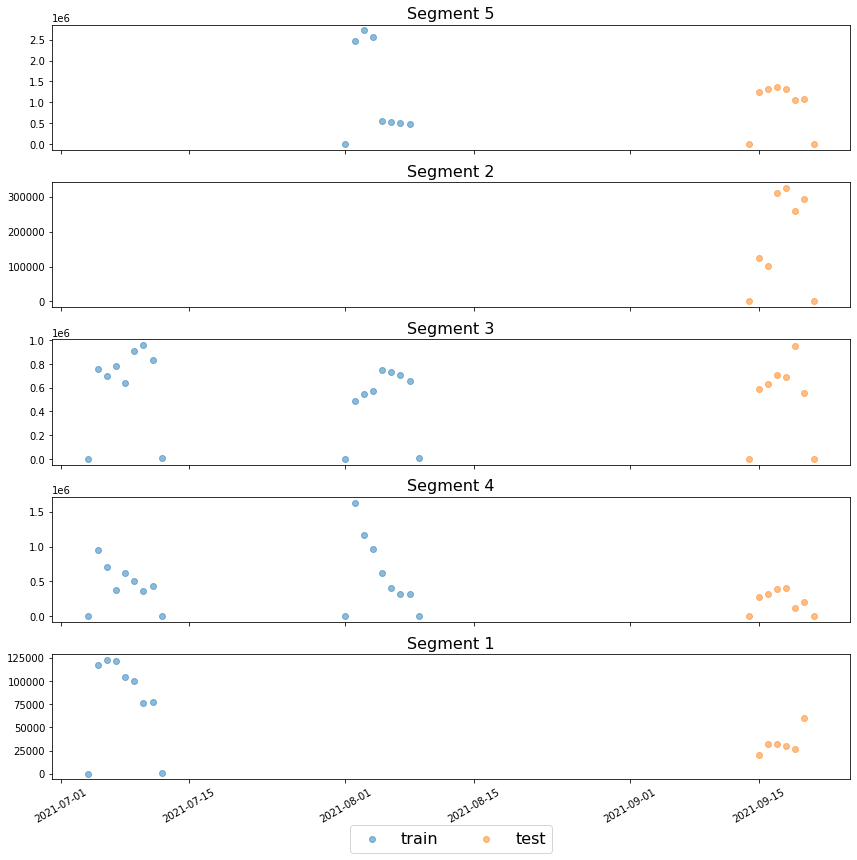

In [16]:
new_figure = True
count = 0
fig, ax = plt.subplots(nrows=5, figsize=(12, 12), sharex=True)

for segment in test['Segment'].unique():   
    
    mask = train['Segment'] == segment
    fast_plot(train[mask].set_index('created').groupby('date')['Segment'].count(), 
              plot=False, new_figure=new_figure, title=f'Segment {segment}', label='train', ax=ax[count])
    new_figure = False
    mask = test['Segment'] == segment
    fast_plot(test[mask].set_index('created').groupby('date')['Segment'].count(), ax=ax[count], 
              plot=False, new_figure=new_figure, label='test')
    plt.xticks(rotation=30)
    new_figure = True
    
    #plt.show()
    count += 1

fast_legend(pos=(0.5, -0.3))    
plt.tight_layout()

Wall time: 2min 19s


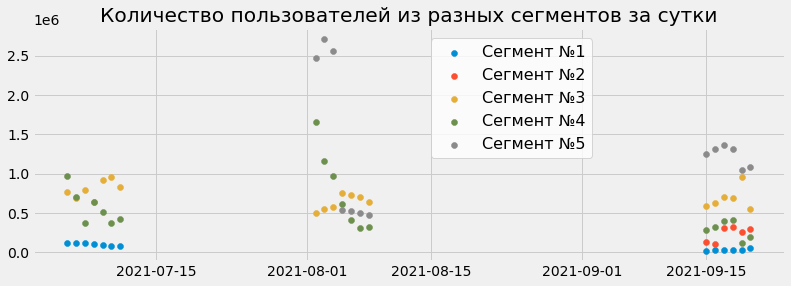

In [22]:
%%time
train['moscow_date'] = train['created'].dt.date
test['moscow_date'] = test['created'].dt.date
data = pd.concat([train, test])
new_figure = True

for segment in range(1, 6): 
    mask = data['Segment'] == segment
    fast_plot(data[mask].set_index('created').groupby('moscow_date')['Segment'].count(), new_figure=new_figure, 
              alpha=1, size=200,
              plot=False, title='Количество пользователей из разных сегментов за сутки', label=f'Сегмент №{segment}')
    new_figure = False

fast_legend(ncol=1, pos=(0.637, 0.99));

# Вопросы

Первая неделя - сегменты 1,3,4  
Вторая неделя - сегменты 3,4,5  
Третья неделя - сегменты 1,2,3,4,5  

<div class="alert alert-warning"> Вопрос: сегментация проводилась в рамках отдельных рекламных кампаний? </div>
<div class="alert alert-warning"> Вопрос: сегменты - это пользователи которые откликнулись на рекламу? </div>

# Сохранение в py файл

In [18]:
%%writefile predict.py

import os
import pickle
import pathlib
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier

# Model params
cat_features = ['gamecategory', 'subgamecategory', 'bundle', 'oblast', 'city', 'os', 'osv']

split_params = {'folds': 5}

model_params = {'objective': 'MultiClass', 
                'iterations':3,
                'learning_rate':0.05,               
                'depth': 4, 
                'l2_leaf_reg': 50,  
                'one_hot_max_size': 15,
                'task_type': 'CPU',
                'has_time': False,
                'random_state': 20210926                
               }

train_params = {'early_stopping_rounds': 150, 
                'silent': True,
                'plot': True               
               }

gpu_params = {'devices': '0',
              'data_partition': 'DocParallel',
              'max_ctr_complexity': 4,
#              'bootstrap_type': 'MVS',
              'border_count': 128, 
              'fold_permutation_block': 0,
              'simple_ctr':'FeatureFreq',
              'combinations_ctr': 'FeatureFreq',      
              'ctr_target_border_count': 1,
              'random_strength': 0.95,
              'gpu_ram_part': 0.95
             }


cpu_params = {'thread_count': 14}

features_params = {'cat_features': cat_features}

observations_params = {"weight": 'not_implemented'}

params = {'split_params': split_params, 
          'model_params': model_params, 
          'train_params': train_params, 
          'gpu_params': gpu_params, 
          'cpu_params': cpu_params, 
          'features_params': features_params, 
          'observations_params': observations_params
         }

def get_time_features(data):
    data['hour_shift'] = data['shift'].apply(lambda x: x.replace('MSK', ''))
    data['hour_shift'] = data['hour_shift'].replace({'': 0, 'missing': 0}).astype('int8')
    
    data['local_time'] = data['created'] + pd.to_timedelta('1H') * data['hour_shift']
    data['month'] = data['local_time'].dt.month.astype('int8')
    data['date'] = data['local_time'].dt.date
    data['day'] = data['local_time'].dt.day.astype('int8')
    data['wd'] = data['local_time'].dt.weekday.astype('int8')
    data['hour'] = data['local_time'].dt.hour.astype('int8')
    data['minutes'] = data['local_time'].dt.minute.astype('int8')
    return data


class Model():
    def __init__(self, params):
        self.params = params
        self.device = params['model_params']['task_type']
        self.model_params = params['model_params']
        self.folds = params['split_params']['folds']        
        self.train_params = params['train_params']
        self.gpu_params = params['gpu_params']
        self.cpu_params = params['cpu_params']
        self.features_params = params['features_params']
        self.observations_params = params['observations_params'] 
        self.models = []
        self.model_predictions = []
        self.predictions_summary = None        
        self.importance = []
        self.features = None
        
    def fit(self, X, y): 
        self.features = X.columns
        self.model_params = self.model_params | self.gpu_params if self.device == 'GPU' else \
            self.model_params | self.cpu_params   
        
        for fold in range(self.folds):
            print(f'\nFold: {fold + 1}')
            self.model_params['random_state'] += 1 
            
            if self.folds > 1:
                train_idx = [x for x in range(X.shape[0]) if x%self.folds != fold]
                val_idx = [x for x in range(X.shape[0]) if x%self.folds == fold]            
            
                X_train = X.iloc[train_idx]
                y_train = y.iloc[train_idx]
            
                X_val = X.iloc[val_idx]
                y_val = y.iloc[val_idx] 
            else:
                X_train = X
                y_train = y

            train_dataset = Pool(data=X_train, label=y_train, **self.features_params)                
           
            model = CatBoostClassifier(**self.model_params)    
            
            if self.folds > 1:
                eval_dataset = Pool(data=X_val, label=y_val, **self.features_params)  
                model.fit(train_dataset, eval_set=eval_dataset, **self.train_params)
            else:
                model.fit(train_dataset,  **self.train_params)
            
            self.models.append(model.copy())   

        self.calculate_importance()
            
        
    def predict(self, X):
        self.model_predictions = []
        for model_number in range(self.folds):    
            model = self.models[model_number]
            columns = [str(x) + '__' + str(model_number) for x in model.get_all_params()['class_names']]
            df = pd.DataFrame(data=model.predict_proba(X), columns=columns)
            self.model_predictions.append(df)  
    
        self.predictions_summary = pd.concat(self.model_predictions, axis=1)

        labels = model.get_all_params()['class_names']
        for label in labels:
            label_columns = [x for x in self.predictions_summary.columns if f'{label}__' in str(x)]
            self.predictions_summary[label] = self.predictions_summary[label_columns].mean(axis=1)

        self.predictions_summary['prediction'] = self.predictions_summary[labels].idxmax(axis=1)
        self.predictions_summary['confidence'] = self.predictions_summary[labels].max(axis=1)
                    
        return self.predictions_summary  
  
   
    def save_models(self, path):
        for model_number, model in enumerate(self.models):
            model.save_model(path + f"model{model_number}.cbm")
            
    def load_models(self, path, file_prefix=''):
        for model_number in range(self.folds):
            model = CatBoostClassifier()
            model.load_model(path.joinpath(f"{file_prefix}model{model_number}.cbm"))
            self.models.append(model.copy())
            
    def calculate_importance(self):
        for model_number in range(self.folds):
            fi_dict = list(zip(self.features, self.models[model_number].feature_importances_))
            importance_df = pd.DataFrame.from_records(fi_dict).set_index(0)
            importance_df.columns = ['importance']
            importance_df = importance_df.sort_values('importance', ascending=False)
            self.importance.append(importance_df) 
            

def predict(data: pd.DataFrame) -> pd.DataFrame:
    data = data.fillna('missing')
    data = get_time_features(data)
    
    model = Model(params)    
    model.load_models(path=pathlib.Path(__file__).parent, file_prefix='models/segmentation_model_')
    predictions = model.predict(data[model.models[0].feature_names_])
    
    return predictions

Overwriting predict.py


# Проверка работы модели

In [19]:
import pathlib
import pickle
import numpy as np
import pandas as pd

import predict as predict

In [20]:
with open('../data/processed/test.pcl', 'rb') as f:
    test = pickle.load(f)
    
df_test = test.iloc[:1000][['Segment', 'gamecategory', 'subgamecategory', 
                            'bundle', 'created', 'shift', 'oblast', 'city', 'os', 'osv']]

In [21]:
predict.predict(df_test)

,1__0,3__0,4__0,5__0,1__1,3__1,4__1,5__1,1__2,3__2,...,1__4,3__4,4__4,5__4,1,3,4,5,prediction,confidence
0,0.036571,0.815093,0.146378,0.001958,0.038559,0.798106,0.162335,0.001000,0.041130,0.798785,...,0.035857,0.814460,0.148453,0.001230,0.037260,0.804881,0.156245,0.001615,3,0.804881
1,0.033902,0.855992,0.108711,0.001396,0.034551,0.853624,0.111196,0.000630,0.035214,0.863697,...,0.032227,0.854830,0.111795,0.001148,0.033639,0.854699,0.110422,0.001240,3,0.854699
2,0.019507,0.928697,0.051730,0.000065,0.018516,0.937473,0.043991,0.000019,0.021060,0.930941,...,0.019368,0.931247,0.049332,0.000052,0.019559,0.931052,0.049342,0.000047,3,0.931052
3,0.031424,0.853468,0.113826,0.001282,0.031154,0.857299,0.110888,0.000659,0.031834,0.858007,...,0.029806,0.856647,0.112620,0.000927,0.030773,0.854091,0.114052,0.001084,3,0.854091
4,0.033389,0.854706,0.110488,0.001416,0.033964,0.852665,0.112641,0.000730,0.034153,0.865313,...,0.030934,0.852642,0.115322,0.001102,0.032782,0.853504,0.112453,0.001261,3,0.853504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.121880,0.835836,0.042279,0.000006,0.095849,0.846359,0.057781,0.000011,0.099842,0.846329,...,0.100550,0.846919,0.052525,0.000006,0.107673,0.834012,0.058302,0.000013,3,0.834012
996,0.030480,0.854790,0.113213,0.001517,0.029487,0.859316,0.110381,0.000816,0.031414,0.864150,...,0.029506,0.859457,0.109974,0.001063,0.030030,0.856671,0.111958,0.001340,3,0.856671
997,0.060138,0.513431,0.426315,0.000116,0.044534,0.584589,0.370794,0.000082,0.054654,0.587771,...,0.061677,0.447231,0.491044,0.000049,0.053131,0.541443,0.405298,0.000128,3,0.541443
998,0.061943,0.889933,0.048100,0.000024,0.037877,0.886641,0.075459,0.000023,0.040647,0.895102,...,0.035613,0.921202,0.043170,0.000016,0.044304,0.888320,0.067340,0.000037,3,0.888320
